# Modélisation de la variable émissions de CO₂

**Rappel de l'objectif**

L'objectif de ce projet est de prédire les émissions de CO₂ ainsi que la consommation totale d'énergie des bâtiments non résidentiels de la ville de Seattle à partir de leurs caractéristiques structurelles (surface, usage, année de construction, localisation, etc.).  
Cette démarche s’inscrit dans l’objectif global de neutralité carbone fixé par la ville à l’horizon 2050.

**Contexte du notebook**

Dans ce notebook, nous allons préparer les données, entraîner des modèles et analyser les résultats liés à la prédiction des **émissions de gaz à effet de serre (GHGEmissionsIntensity)**

Le jeu de données a été préalablement nettoyé et préparé dans le fichier `notebook_1.ipynb`.

## Sommaire

1. **Préparation des features pour la modélisation**
2. **Optimisation des hyperparamètres (GridSearchCV)**
3. **Évaluation avec le jeu de données de validation**
4. **Analyse de l'impact de ENERGYSTARScore**
5. **Conclusion et recommandations**


## Préparation des features pour la modélisation
### Configuration du notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import time
import seaborn as sns



#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
	KFold
)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance
from sklearn.base import clone

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid")

# Constantes
TARGET_CO2 = 'GHGEmissionsIntensity'
TARGET_ENERGY = 'SiteEUIWN(kBtu/sf)'
CIBLES = [TARGET_ENERGY, TARGET_CO2]

TEST_SIZE = 0.2
RANDOM_STATE = 42
N_SPLITS = 5 # Choix standard pour la validation croisée


# Chargement des données
df_origin = pd.read_csv('data/data_train_test_clean.csv')

df = df_origin.copy()

print("📊 Dataset chargé")
print(f"   Shape : {df.shape}")
print(f"   Lignes : {len(df):,} bâtiments")
print(f"   Colonnes : {df.shape[1]}")


📊 Dataset chargé
   Shape : (1151, 28)
   Lignes : 1,151 bâtiments
   Colonnes : 28


### Composition de X et y

`X` regroupe l’ensemble des features, à l’exception de `ENERGYSTARScore`, ainsi que les deux variables cibles.  
Nous testerons dans un second temps l’ajout de `ENERGYSTARScore` afin d’évaluer son impact sur les performances du modèle.

`y` correspond à la variable cible `GHGEmissionsIntensity`.
La variable `SiteEUIWN(kBtu/sf)` sera quant à elle modélisée et analysée dans un autre notebook.

In [2]:
def split_features_targets(df: pd.DataFrame, columns_to_drop: List[str], target: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Sépare les features et la variable cible.
    
    Parameters
    ----------
    df : DataFrame contenant toutes les colonnes
    columns_to_drop : colonnes à exclure des features
    target : nom de la variable cible
    
    Returns
    -------
    X : DataFrame des features
    y : Series de la variable cible
    """
    X = df.drop(columns=columns_to_drop)
    y = df[target]
    return X, y

X, y = split_features_targets(df, CIBLES + ['ENERGYSTARScore'], TARGET_CO2)

assert X.isna().sum().sum() == 0, "Valeurs manquantes détectées dans X"
assert y.isna().sum() == 0, "Valeurs manquantes détectées dans y"

print(f"X : {X.shape}")
print(f"y : {y.shape}")



X : (1151, 25)
y : (1151,)


### Encodage des variables catégorielles

Transformer les variables catégorielles en variables numériques pour que les algorithmes de Machine Learning puissent les utiliser.

**LabelEncoder** : transforme chaque catégorie textuelle en un entier unique, mais introduit un ordre artificiel entre les catégories, ce qui peut biaiser le modèle si les catégories ne sont pas ordinales.

**OneHotEncoder** : transforme une variable catégorielle en plusieurs variables binaires (0/1), cela évite d'introduire une relation d'ordre artificielle qui pourrait biaiser les modèles sensibles à l'ordre des valeurs

In [3]:
def identify_feature_types(X: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """Identifie les features catégorielles et numériques dans un DataFrame."""
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    return categorical_features, numeric_features

X_categorical, X_numeric = identify_feature_types(X)

print(f"\nDimensions de X AVANT encodage : {X.shape}")
print(f"  • Features numériques : {len(X_numeric)}")
print(f"  • Features catégorielles : {len(X_categorical)}")

# Calcul du nombre de catégories uniques par variable
n_categories = (
    df[X_categorical]
    .nunique()
    .reset_index()
)

n_categories.columns = ["Variable", "Nombre_de_categories"]

n_categories


Dimensions de X AVANT encodage : (1151, 25)
  • Features numériques : 21
  • Features catégorielles : 3


,Variable,Nombre_de_categories
0,BuildingType,4
1,PrimaryPropertyType,21
2,Neighborhood,13


#### Stratégie d'encodage

- **BuildingType (4)** : OneHotEncoder, car il y a peu de catégories et aucun ordre naturel.
- **Neighborhood (13)** : OneHotEncoder, car le nombre de catégories reste raisonnable et aucun ordre naturel.
- **PrimaryPropertyType (21)** : OneHotEncoder, car le nombre de catégories reste raisonnable et aucun ordre naturel.


### Prétraitement des données

Avant d’entraîner le modèle, il est nécessaire de préparer les données afin qu’elles soient exploitables efficacement.

- **StandardScaler** : StandardScaler est un outil de normalisation qui applique la standardisation par z-score aux variables numériques. La standardisation facilite l'interprétation des coefficients et est essentielle pour les algorithmes sensibles à l'échelle comme

- **ColumnTransformer** : permet d’appliquer des transformations différentes selon les colonnes du dataset. Ici, les variables numériques sont standardisées avec `StandardScaler`, tandis que les variables catégorielles sont encodées avec `OneHotEncoder`, le tout dans une seule étape cohérente et reproductible.


In [4]:
# Créer un preprocessor avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_categorical)
    ]
)


### Modèles
Voici les différents modèles choisie :

- **Dummy** : Modèle de référence basique qui prédit toujours la moyenne des valeurs cibles, utilisé comme baseline pour évaluer les performances des autres modèles.

- **LinearRegression** : Modèle de régression linéaire qui établit une relation linéaire entre les variables d'entrée et la variable cible en minimisant l'erreur quadratique.

- **SVR** : Support Vector Regression, qui utilise les concepts des machines à vecteurs de support pour effectuer une régression en trouvant un hyperplan optimal dans un espace de grande dimension.

- **RandomForestRegressor** : Ensemble d'arbres de décision qui combine les prédictions de multiples arbres pour améliorer la précision et réduire le surapprentissage.

In [5]:
models = {
    "Dummy": DummyRegressor(strategy="mean"),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(),
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE)
}

### Métriques

La **MAE (Mean Absolute Error)** mesure l'écart moyen entre les prédictions et les valeurs réelles, en prenant la valeur absolue des erreurs. Elle est simple à interpréter, mais ne différencie pas entre les petites et les grandes erreurs.

Le **RMSE (Root Mean Squared Error)** met en valeur les grandes erreurs en les élevant au carré avant de calculer la racine carrée. Il est donc plus sensible aux prédictions extrêmes que la MAE.

Le **R²** évalue la performance du modèle par rapport à un modèle de base (Dummy Regressor) et peut varier de 1 (parfait) à des valeurs négatives (pire qu’un modèle aléatoire). Il n'est pas un pourcentage et peut être trompeur sans contexte.

L'utilisation conjointe de ces trois métriques permet :
- MAE : interprétabilité directe (erreur moyenne en unité de la cible)
- RMSE : sensibilité aux grandes erreurs
- R² : comparaison avec le modèle baseline


### Validation croisée

In [6]:
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [7]:
def train_and_evaluate_model_cv(model, X_train, y_train, cv):
    """
    Évalue un modèle de régression par validation croisée, puis entraîne
    le modèle sur l'ensemble du jeu d'entraînement.

    La fonction effectue une validation croisée afin de calculer les
    performances moyennes sur les folds (train et validation) pour
    plusieurs métriques, mesure le temps d'exécution total, puis ajuste
    le modèle sur toutes les données d'entraînement.

    Paramètres
    ----------
    model : estimator scikit-learn
        Modèle de régression compatible scikit-learn implémentant les
        méthodes `fit` et `predict`.

    X_train : array-like of shape (n_samples, n_features)
        Données d'entraînement.

    y_train : array-like of shape (n_samples,)
        Variable cible associée aux données d'entraînement.

    cv : int or cross-validation generator
        Stratégie de validation croisée (par exemple nombre de folds
        ou objet `KFold`, `StratifiedKFold`, etc.).

    Retours
    -------
    results : dict
        Dictionnaire contenant :
        - r2_cv_train : float
            Score R² moyen sur les folds d'entraînement.
        - mae_cv_train : float
            MAE moyenne sur les folds d'entraînement.
        - rmse_cv_train : float
            RMSE moyenne sur les folds d'entraînement.
        - r2_cv_test : float
            Score R² moyen sur les folds de validation.
        - mae_cv_test : float
            MAE moyenne sur les folds de validation.
        - rmse_cv_test : float
            RMSE moyenne sur les folds de validation.
        - r2_train_test_gap : float
            Différence entre le R² moyen train et validation.
        - duration : float
            Temps total d'exécution en secondes.
        - model_fitted : estimator scikit-learn
            Modèle entraîné sur l'ensemble du jeu d'entraînement.
    """
    start = time.time()
    # Entraîner le modèle sur toutes les données d'entraînement
    model_fitted = clone(model)

    # Validation croisée sur le jeu d'entraînement
    cv_results = cross_validate(
        model_fitted,
        X_train,
        y_train,
        cv=cv,
        scoring={
            "r2": "r2",                         # Coefficient de détermination R²
            "mae": "neg_mean_absolute_error",   # Erreur absolue moyenne (négative par convention sklearn)
            "rmse": "neg_root_mean_squared_error"  # Racine de l'erreur quadratique moyenne (négative)
        },
        # Retourne également les scores sur les folds d'entraînement
        # Utile pour détecter l'overfitting ou l'underfitting
        return_train_score=True,
        # Utilise tous les cœurs du processeur pour accélérer le calcul
        n_jobs=-1
    )

    model_fitted.fit(X_train, y_train)

    duration = time.time() - start

    # Moyennes des scores de validation croisée
    r2_cv_train = cv_results['train_r2'].mean()
    mae_cv_train = -cv_results['train_mae'].mean()
    rmse_cv_train = -cv_results['train_rmse'].mean()

    r2_cv_test = cv_results['test_r2'].mean()
    mae_cv_test = -cv_results['test_mae'].mean()
    rmse_cv_test = -cv_results['test_rmse'].mean()


    return {
        'r2_cv_train': r2_cv_train,
        'mae_cv_train': mae_cv_train,
        'rmse_cv_train': rmse_cv_train,
        'r2_cv_test': r2_cv_test,
        'mae_cv_test': mae_cv_test,
        'rmse_cv_test': rmse_cv_test,
        'r2_train_test_gap': r2_cv_train - r2_cv_test,
        'duration_cv': duration,
        'model_fitted': model_fitted
    }

In [8]:
def evaluate_model_validation(model, X_val, y_val, feature_names):
    """
    Évalue un modèle de régression entraîné sur un jeu de validation
    et calcule l'importance des variables par permutation.

    Paramètres
    ----------
    model : estimator scikit-learn
        Modèle de régression déjà entraîné implémentant les méthodes
        `predict`.

    X_val : array-like of shape (n_samples, n_features)
        Données de validation.

    y_val : array-like of shape (n_samples,)
        Valeurs cibles du jeu de validation.
    
    feature_names : array-like
        Noms des features pour le DataFrame d'importance.

    Retours
    -------
    results : dict
        Dictionnaire contenant :
        - r2 : float
            Score R² sur le jeu de validation.
        - mae : float
            Erreur absolue moyenne (MAE) sur le jeu de validation.
        - rmse : float
            Racine de l'erreur quadratique moyenne (RMSE) sur le jeu de validation.
        - importance_df : pandas.DataFrame
            DataFrame contenant l'importance moyenne et l'écart-type
            de chaque variable calculés par permutation, trié par
            importance décroissante.
    """
    start = time.time()

    y_pred = model.predict(X_val)

    duration = time.time() - start

    # Calcul de l'importance des variables par permutation
    perm_importance = permutation_importance(
        model,
        X_val,
        y_val,
        n_repeats=10, # Nombre de permutations aléatoires par variabl
        random_state=RANDOM_STATE, # Aléatoire pour garantir la reproductibilité des résultats
        n_jobs=-1, # Utilise tous les cœurs du processeur pour accélérer le calcul
        scoring='neg_mean_absolute_error' # Métrique utilisée pour mesurer la dégradation des performances
    )

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)

    return {
        'r2': r2_score(y_val, y_pred),
        'mae': mean_absolute_error(y_val, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, y_pred)),
        'duration': duration,
        'importance_df': importance_df
    }

In [9]:
def plot_bar(
    df,
    x,
    y,
    ax,
    title=None,
    xlabel=None,
    ylabel=None,
    palette=None,
    rotation=45
):
    sns.barplot(data=df, x=x, y=y, hue=x, palette=palette, ax=ax)


    ax.set_title(title if title else f"{y} par {x}")
    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else y)
    ax.tick_params(axis="x", rotation=rotation)



def plot_metric_comparison(
    df,
    id_col,
    metrics,
    value_name,
    ax,
    title,
    xlabel="Modèle",
    rotation=45
):
    df_melt = df.melt(
        id_vars=id_col,
        value_vars=metrics,
        var_name="Dataset",
        value_name=value_name
    )

    sns.barplot(
        data=df_melt,
        x=id_col,
        y=value_name,
        hue="Dataset",
        ax=ax
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.tick_params(axis="x", rotation=rotation)


In [10]:
results_all_models  = []

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)
# Transformer les données
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

for model_name, model in models.items():
    print(f"\nModèle en cours : {model_name}")
    results_cv = train_and_evaluate_model_cv(model, X_train_preprocessed, y_train, kfold)
    results_val = evaluate_model_validation(results_cv['model_fitted'], X_test_preprocessed, y_test, feature_names)
    results = {
        'model_name': model_name,
        **results_val,
        **results_cv
    }
    results_all_models .append(results)


Modèle en cours : Dummy

Modèle en cours : LinearRegression

Modèle en cours : SVR

Modèle en cours : RandomForest


Métriques de validation croisée


,model_name,r2_cv_train,r2_cv_test,mae_cv_test,rmse_cv_test,r2_train_test_gap,duration_cv
0,Dummy,0.00,-0.00,1.11,1.54,0.00,1.93
1,LinearRegression,0.60,0.51,0.72,1.08,0.10,0.11
2,SVR,0.49,0.36,0.70,1.23,0.13,0.16
3,RandomForest,0.93,0.49,0.68,1.10,0.44,1.28


Métriques sur jeu de test final


,model_name,r2,mae,rmse,duration
0,Dummy,-0.00,1.12,1.53,0.00
1,LinearRegression,0.49,0.76,1.10,0.00
2,SVR,0.38,0.69,1.21,0.01
3,RandomForest,0.53,0.65,1.04,0.01


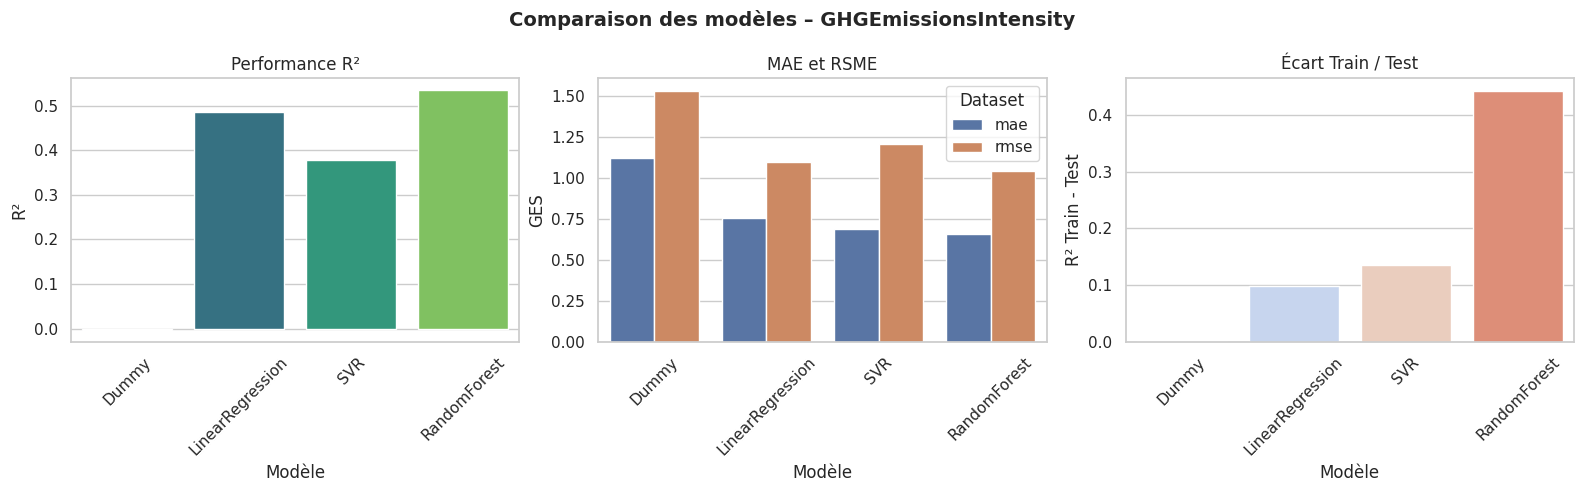

In [11]:
def display_results_models(results_list: List[dict], columns_to_show : List[str] = []):
    df = pd.DataFrame(results_list)
    display(df[columns_to_show].round(2))


def plot_model_comparison(results_all_models, suptitle):
    df_models = pd.DataFrame(results_all_models)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(
        suptitle,
        fontsize=14,
        fontweight="bold"
    )

    # R²
    plot_bar(
        df_models,
        x="model_name",
        y="r2",
        ax=axes[0],
        ylabel="R²",
        title="Performance R²",
        palette="viridis",
        xlabel="Modèle"
    )

    # MAE Train / Test
    plot_metric_comparison(
        df_models,
        id_col="model_name",
        metrics=["mae", "rmse"],
        value_name="GES",
        ax=axes[1],
        title="MAE et RSME",
        xlabel="Modèle"
    )

    # Overfitting gap
    plot_bar(
        df_models,
        x="model_name",
        y="r2_train_test_gap",
        ax=axes[2],
        ylabel="R² Train - Test",
        title="Écart Train / Test",
        palette="coolwarm",
        xlabel="Modèle"
    )

    plt.tight_layout()
    plt.show()


print("Métriques de validation croisée")
display_results_models(results_all_models, ['model_name', 'r2_cv_train', 'r2_cv_test', 'mae_cv_test', 'rmse_cv_test', 'r2_train_test_gap', 'duration_cv'])
print("Métriques sur jeu de test final")
display_results_models(results_all_models, ['model_name', 'r2', 'mae', 'rmse', 'duration'])

plot_model_comparison(results_all_models, "Comparaison des modèles – GHGEmissionsIntensity")

**Observations**

Les modèles Dummy et SVR obtiennent un R² proche de 0, ce qui signifie qu'ils ne parviennent pas à expliquer correctement les émissions de CO₂. Pour SVR, cela peut s'expliquer par les paramètres par défaut qui ne sont pas adaptés à ce jeu de données.

Le modèle **RandomForest** se distingue nettement avec un R² de **0.53 sur le jeu de test**, surpassant la régression linéaire. Cependant, l'écart important entre le R² d'entraînement (0.93) et de test (0.53) révèle un **surapprentissage prononcé** (gap de 0.44).

Les erreurs sont relativement faibles : MAE de **0.65 kgCO₂e/sf** et RMSE de **1.04 kgCO₂e/sf**, ce qui est encourageant pour la prédiction des émissions.

**Choix du modèle**

Nous choisissons le modèle RandomForest, car il offre les meilleures performances globales. Une optimisation des hyperparamètres sera réalisée afin de réduire le surapprentissage observé.


## Optimisation des hyperparamètres (GridSearchCV)

Afin d’améliorer les performances du modèle **RandomForest**, nous utilisons un **GridSearchCV** en ajustant plusieurs hyperparamètres clés. L’objectif principal est de **réduire le surapprentissage**, identifié lors de l’étape d’évaluation des modèles.

**GridSearchCV** est une fonction qui permet à la fois d'implémenter une validation croisée et de sélectionner les paramètres optimaux du modèle.

`n_estimators` — Nombre d'arbres
- Plus le nombre d'arbres est élevé, plus le modèle est stable
- Les prédictions sont moyennées, ce qui réduit la variance

`max_depth` — Profondeur maximale des arbres
- Limite la complexité de chaque arbre
- Empêche l'apprentissage de règles trop spécifiques aux données d'entraînement

`min_samples_split` — Minimum d'exemples pour diviser un nœud
- Empêche la création de splits basés sur trop peu d'observations
- Réduit les décisions instables ou peu représentatives

`min_samples_leaf` — Minimum d'exemples par feuille
- Force chaque prédiction finale à reposer sur un nombre suffisant d'exemples
- Améliore la stabilité et la capacité de généralisation du modèle

`max_features` — Nombre de features considérées pour chaque split
- Introduit de la randomisation en limitant les variables disponibles à chaque division
- 'sqrt' utilise la racine carrée du nombre total de features, 0.5 en utilise la moitié
- Réduit la corrélation entre les arbres et améliore la diversité de l'ensemble


In [12]:
def gridsearch_random_forest(X_train, y_train, kfold, param_grid):
    """
    Optimise les hyperparamètres d'un RandomForest via GridSearchCV.
    
    Retour
    ------
    dict avec structure standardisée + best_params et best_model
    """
    start = time.time()
    grid_rf = GridSearchCV(
        estimator=RandomForestRegressor(random_state=RANDOM_STATE),
        param_grid=param_grid,
        cv=kfold,
        scoring= {
            'r2': 'r2',
            'mae': 'neg_mean_absolute_error',
            'rmse': 'neg_root_mean_squared_error'
        },
        refit='r2',
        n_jobs=-1,
        return_train_score=True
    )

    grid_rf.fit(X_train, y_train)

    duration = time.time() - start

    best_idx = grid_rf.best_index_
    cv = grid_rf.cv_results_

    return {
        "best_model": grid_rf.best_estimator_,
        "best_params": grid_rf.best_params_,
        "best_cv_r2": grid_rf.best_score_,
        'r2_cv_train': cv['mean_train_r2'][best_idx],
        'r2_cv_test': cv['mean_test_r2'][best_idx],
        'r2_train_test_gap': (
            cv['mean_train_r2'][best_idx] - cv['mean_test_r2'][best_idx]
        ),

        'mae_cv_train': -cv['mean_train_mae'][best_idx],
        'mae_cv_test': -cv['mean_test_mae'][best_idx],

        'rmse_cv_train': -cv['mean_train_rmse'][best_idx],
        'rmse_cv_test': -cv['mean_test_rmse'][best_idx],
        'duration': duration
    }

In [13]:
param_grid_rf = {
    'n_estimators': [150, 200, 250],
    'max_depth': [10, 12, 18, 25],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 5, 8],
    'max_features': ['sqrt', 0.5, 0.7]
}


results_gridsearch = gridsearch_random_forest(
    X_train_preprocessed,
    y_train,
    kfold,
    param_grid_rf
)

results_val_best_model = evaluate_model_validation(results_gridsearch['best_model'], X_test_preprocessed, y_test, feature_names)



📊 RÉSULTATS FINAUX - MEILLEURS MODÈLES RANDOM FOREST
Métriques de validation croisée


,model_name,r2_cv_train,r2_cv_test,mae_cv_test,rmse_cv_test,r2_train_test_gap
0,RandomForest,0.93,0.49,0.68,1.10,0.44
1,RFR Optimisé,0.77,0.48,0.68,1.11,0.29


Métriques sur jeu de test final


,model_name,r2,mae,rmse
0,RandomForest,0.53,0.65,1.04
1,RFR Optimisé,0.54,0.66,1.04



🔧 MEILLEURS PARAMÈTRES PAR CIBLE

{'max_depth': 12, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 150}


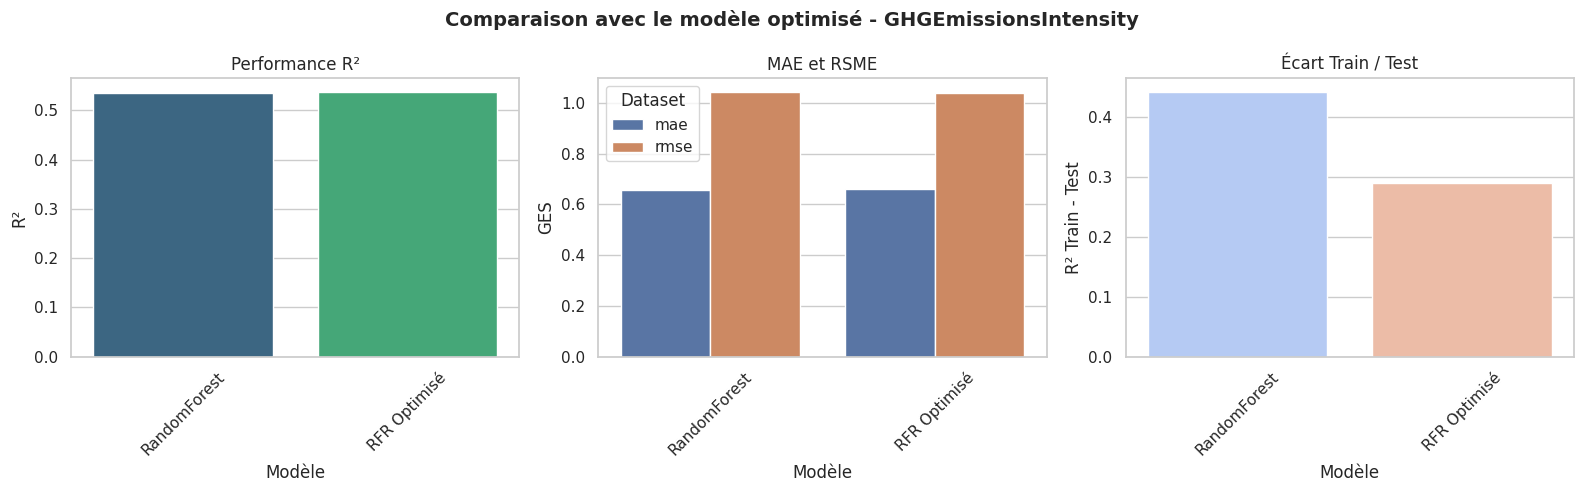

In [14]:
results_best_model = {
    'model_name': "RFR Optimisé",
    **results_val_best_model,
    **results_gridsearch
}

rf_avant = next(
    r for r in results_all_models
    if r["model_name"] == "RandomForest"
)

print("\n" + "="*80)
print("📊 RÉSULTATS FINAUX - MEILLEURS MODÈLES RANDOM FOREST")
print("="*80)

print("Métriques de validation croisée")
display_results_models([rf_avant, results_best_model], ['model_name', 'r2_cv_train', 'r2_cv_test', 'mae_cv_test', 'rmse_cv_test', 'r2_train_test_gap'])
print("Métriques sur jeu de test final")
display_results_models([rf_avant, results_best_model], ['model_name', 'r2', 'mae', 'rmse'])
print("\n🔧 MEILLEURS PARAMÈTRES PAR CIBLE\n")
print(results_best_model['best_params'])

plot_model_comparison([rf_avant, results_best_model], "Comparaison avec le modèle optimisé - GHGEmissionsIntensity")

**Observations**

L'optimisation des hyperparamètres a permis de réduire significativement le surapprentissage :

| Métrique | Avant optimisation | Après optimisation | Évolution |
|----------|-------------------|-------------------|-----------|
| R² (test) | 0.53 | 0.54 | +2% |
| R² (train CV) | 0.93 | 0.77 | -17% |
| Gap train/test | 0.44 | 0.29 | -34% |

**Analyse du compromis biais-variance :**
- Le R² d'entraînement a baissé de 0.93 à 0.77, ce qui est **souhaitable** : le modèle mémorise moins les données d'entraînement
- Le gap train/test a été réduit de 0.44 à 0.29, indiquant une **meilleure généralisation**
- Le R² sur le jeu de test reste stable (~0.54), confirmant que le modèle n'a pas perdu en performance prédictive

**Paramètres optimaux retenus :**
- `max_depth=12` : limite la profondeur des arbres
- `min_samples_leaf=3` et `min_samples_split=5` : impose un minimum d'observations par nœud
- `max_features=0.5` : utilise 50% des features à chaque split
- `n_estimators=150` : nombre d'arbres modéré mais suffisant

Le modèle optimisé présente un meilleur équilibre entre apprentissage et généralisation.



## Evaluation avec le jeu de donnée de validation

Le jeu de validation provient du **split initial réalisé dans le notebook 1** :
- Split stratifié 80/20 effectué **avant** tout prétraitement
- 80% → entraînement et test (ce notebook)
- 20% → validation finale (fichier `data_val_clean_with_energystart.csv`)

Ce jeu n'a **jamais été utilisé** durant la phase d'entraînement ou d'optimisation des hyperparamètres. Il permet d'évaluer la capacité de généralisation réelle du modèle sur des données totalement inédites.

Le même pipeline de nettoyage et de feature engineering a été appliqué aux deux jeux de données pour garantir la cohérence.

In [15]:
# Charger les données de validation
data_val = pd.read_csv('data/data_val_clean.csv')  # Adaptez le chemin

# Séparer les features et les cibles
X_val, y_val = split_features_targets(data_val, CIBLES + ['ENERGYSTARScore'], TARGET_CO2)

X_val_preprocessed  = preprocessor.transform(X_val)

results_validation = {}

results_validation = evaluate_model_validation(results_best_model['best_model'], X_val_preprocessed , y_val, feature_names)

results_validation = {
	'model_name' : "RFR Optimisé (data validation)",
	**results_validation
}


,model_name,r2,mae,rmse
0,RFR Optimisé,0.54,0.66,1.04
1,RFR Optimisé (data validation),0.60,0.54,0.87


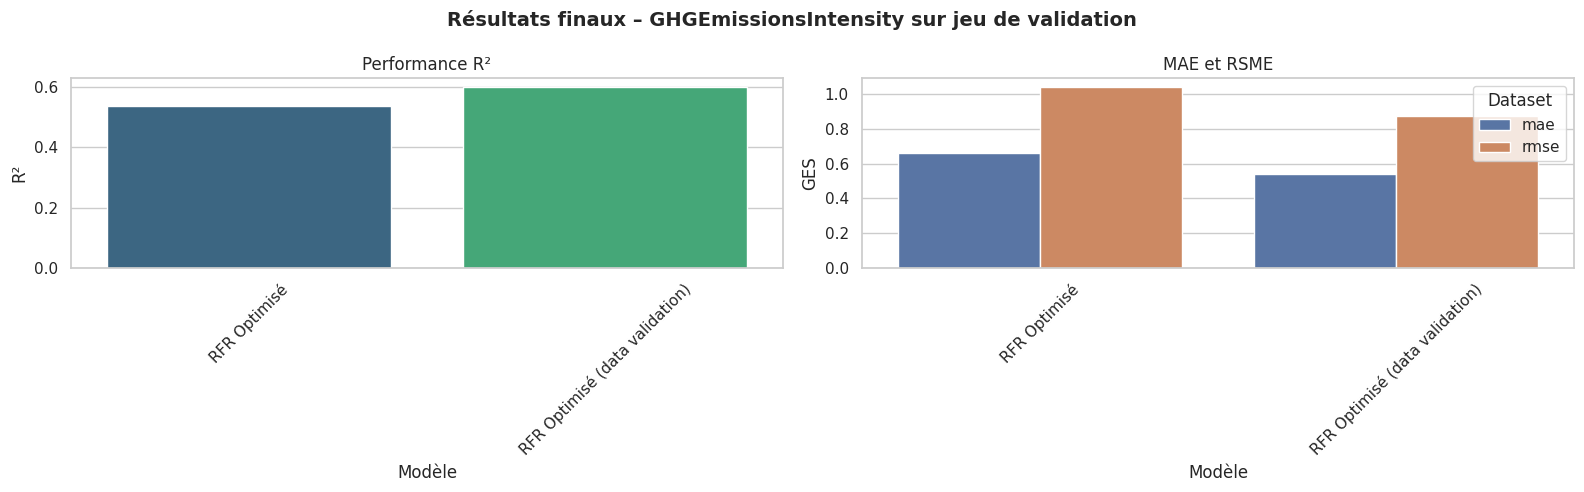

In [16]:
display_results_models([results_best_model, results_validation], ['model_name', 'r2', 'mae', 'rmse'])
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle(
    f"Résultats finaux – {TARGET_CO2} sur jeu de validation",
    fontsize=14,
    fontweight="bold"
)

# R²
plot_bar(
    pd.DataFrame([results_best_model, results_validation]),
    x="model_name",
    y="r2",
    ax=axes[0],
    ylabel="R²",
	xlabel="Modèle",
    title="Performance R²",
    palette="viridis"
)

# MAE Train / Test
plot_metric_comparison(
    pd.DataFrame([results_best_model, results_validation]),
    id_col="model_name",
    metrics=["mae", "rmse"],
    value_name="GES",
    ax=axes[1],
    title="MAE et RSME",
	xlabel="Modèle",
)

plt.tight_layout()
plt.show()

**Observation**

Les performances sur le jeu de validation finale sont supérieures à celles observées sur le jeu de test :

| Jeu de données | R² | MAE | RMSE |
|----------------|-----|-----------------|------------------|
| Test (20% train) | 0.54 | 0.66 | 1.04 |
| Validation finale | 0.60 | 0.54 | 0.87 |

**Interprétation :**

Cette différence peut s'expliquer par plusieurs facteurs :
1. **Variabilité des échantillons** : avec des jeux de données de taille modeste, les performances peuvent varier selon la composition de l'échantillon
2. **Distribution des données** : le jeu de validation peut contenir des bâtiments avec des profils d'émissions plus homogènes
3. **Absence de valeurs extrêmes** : le RMSE nettement plus faible (0.87 vs 1.04) suggère moins d'erreurs importantes sur ce jeu

**Conclusion :** Le modèle généralise correctement sur des données totalement inédites, avec environ **60% de la variance des émissions de CO₂ expliquée**.


🔝 Top 15 features (agrégées) - GHGEmissionsIntensity


,original_feature,importance_mean,importance_std
7,electricity_share,0.547481,0.022371
4,PrimaryPropertyType,0.105929,0.012430
8,energy_source_diversity,0.019723,0.008775
3,NumberofFloors,0.017750,0.003629
1,Neighborhood,0.007581,0.002739
5,building_age,0.006775,0.003944
16,has_steam,0.006567,0.001804
2,NumberofBuildings,0.006200,0.001845
20,parking_ratio,0.005406,0.001362
13,has_natural_gas,0.005289,0.003177


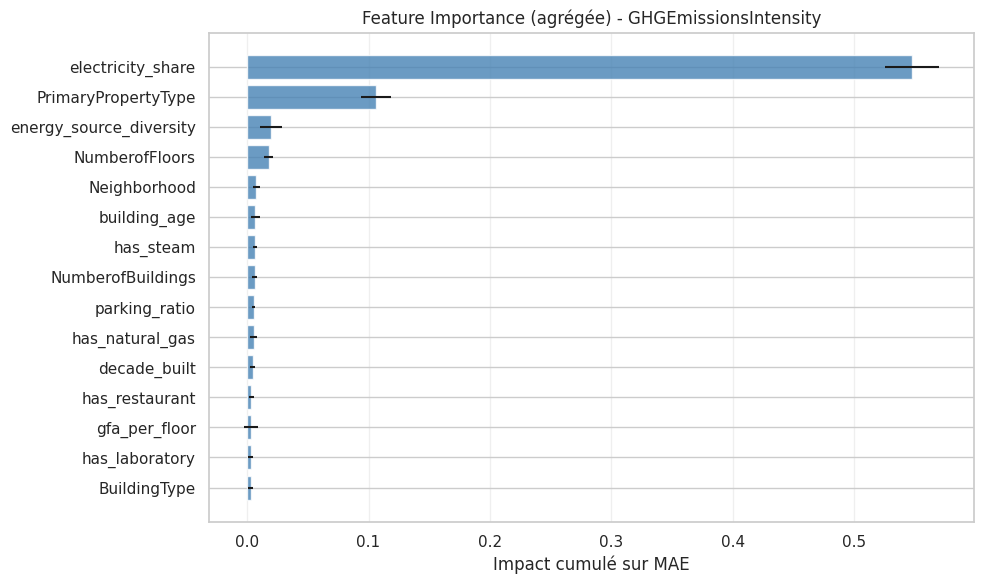

In [17]:
def display_aggregated_features(importance_df, target_name, categorical_features, top_n=10):
    """
    Affiche les features importantes :
    - Noms nettoyés (sans num__, cat__)
    - Variables catégorielles agrégées
    """
    
    # 1. Nettoyer
    df = importance_df.copy()
    df['feature'] = [name.split('__', 1)[-1] for name in df['feature']]

    
    # 2. Agréger
    original_features = []
    for col in df['feature']:
        matched = False
        for cat in categorical_features:
            if col.startswith(cat + "_"):
                original_features.append(cat)
                matched = True
                break
        if not matched:
            original_features.append(col)
    
    df['original_feature'] = original_features
    
    # 3. Grouper
    aggregated = (
        df
        .groupby('original_feature', as_index=False)
        .agg({
            'importance_mean': 'sum',
            'importance_std': lambda x: np.sqrt(np.sum(x**2))
        })
        .sort_values('importance_mean', ascending=False)
        .head(top_n)
    )
    
    # 4. Affichage
    print("\n" + "="*70)
    print(f"🔝 Top {top_n} features (agrégées) - {target_name}")
    print("="*70)
    display(aggregated)
    
    # 5. Graphique
    plt.figure(figsize=(10, 6))
    plt.barh(
        range(len(aggregated)),
        aggregated['importance_mean'].values[::-1],
        xerr=aggregated['importance_std'].values[::-1],
        alpha=0.8,
        color='steelblue'
    )
    plt.yticks(range(len(aggregated)), aggregated['original_feature'].values[::-1])
    plt.xlabel('Impact cumulé sur MAE')
    plt.title(f'Feature Importance (agrégée) - {target_name}')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

display_aggregated_features(results_validation['importance_df'], TARGET_CO2, X_categorical, top_n=15)

#### Variables les plus importantes
- **La part de l'électricité**
- **Type d'usage du bâtiment (PrimaryPropertyType)**


Ces deux éléments expliquent l'essentiel des émissions de CO₂. Le type d'activité détermine directement les besoins énergétiques et donc les émissions associées.

#### Variables d'importance moyenne
- La diversité des énergies
- Nombre d'étage
- Les quartiers
- Âge du bâtiment
- L'utilisation de la vapeur


#### Variables peu importantes
- 

#### Interprétation générale
Les émissions de CO₂ des bâtiments non résidentiels dépendent avant tout de **leur fonction** et de **la part d'utilisation de l'électricité** parmis les différentes sources. 

À noter : les performances du modèle sur les émissions de CO₂ (R² ≈ 0.54-0.60) sont **légèrement supérieures** à celles obtenues sur la consommation d'énergie (R² ≈ 0.40-0.49), ce qui peut s'expliquer par une relation plus directe entre les caractéristiques structurelles et les émissions.


## Analyse de l'impact de ENERGYSTARScore


In [18]:
df_with_energystar = df_origin.copy()
df_with_energystar = df_with_energystar[df_with_energystar['ENERGYSTARScore'].notna()]
print(f"df_with_energystar : {df_with_energystar.shape}")


df_with_energystar : (744, 28)


Nous conservons uniquement les lignes avec une valeur non nulle pour ENERGYSTARScore, ce qui fait passer le dataset de 1 151 à 744 observations.

In [19]:
X_with_energystar, y_with_energystar = split_features_targets(df_with_energystar, CIBLES , TARGET_CO2)

X_categorical_with_es, X_numeric_with_es = identify_feature_types(X_with_energystar)

preprocessor_with_es = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_numeric_with_es),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_categorical_with_es)
    ]
)

In [20]:
results_with_es = []

X_train_es, X_test_es, y_train_es, y_test_es = train_test_split(
    X_with_energystar,
    y_with_energystar,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# Transformer les données
X_train_es_preprocessed = preprocessor_with_es.fit_transform(X_train_es)
X_test_es_preprocessed = preprocessor_with_es.transform(X_test_es)

feature_names_es = preprocessor_with_es.get_feature_names_out()
model_rf = RandomForestRegressor(**results_best_model['best_params'], random_state=RANDOM_STATE)
results_cv_with_es = train_and_evaluate_model_cv(model_rf, X_train_es_preprocessed, y_train_es, kfold)
results_val_with_es = evaluate_model_validation(results_cv_with_es['model_fitted'], X_test_es_preprocessed, y_test_es, feature_names_es)
results_es = {
	'model_name' : "RFR avec ENERGYSTARScore",
	**results_val_with_es,
	**results_cv_with_es
}

Métriques de validation croisée


,model_name,r2_cv_train,r2_cv_test,mae_cv_test,rmse_cv_test,r2_train_test_gap
0,RandomForest,0.93,0.49,0.68,1.10,0.44
1,RFR Optimisé,0.77,0.48,0.68,1.11,0.29
2,RFR avec ENERGYSTARScore,0.86,0.62,0.47,0.82,0.24


Métriques sur jeu de test final


,model_name,r2,mae,rmse
0,RandomForest,0.53,0.65,1.04
1,RFR Optimisé,0.54,0.66,1.04
2,RFR avec ENERGYSTARScore,0.61,0.50,0.88


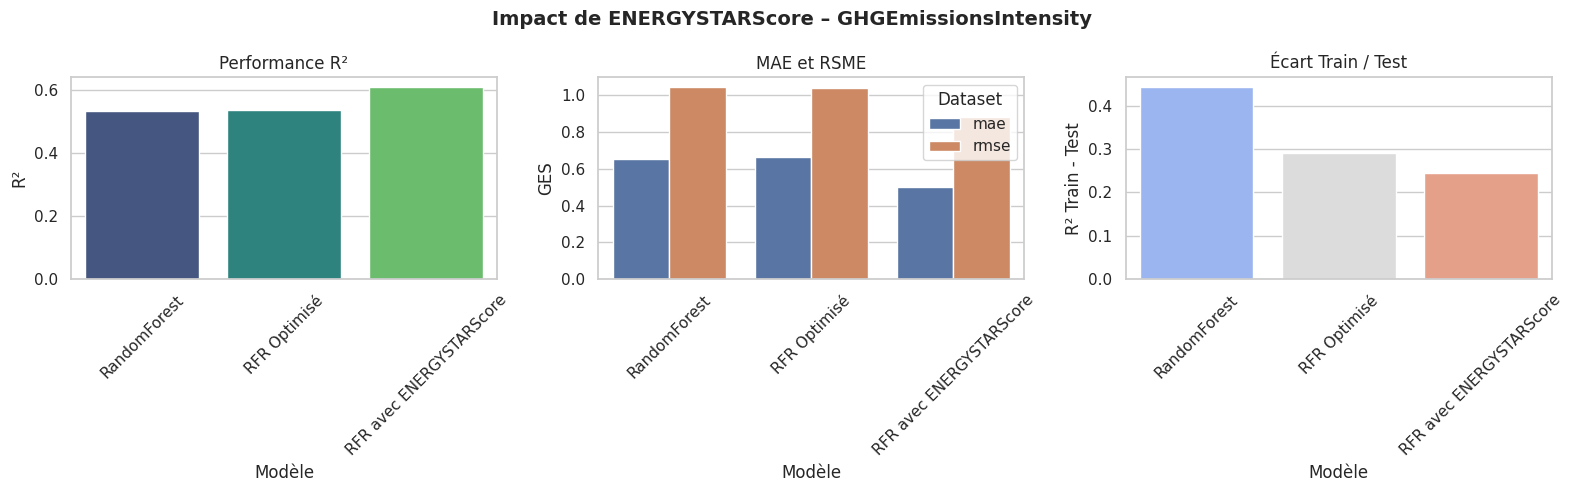

In [21]:
print("Métriques de validation croisée")
display_results_models([rf_avant, results_best_model, results_es], ['model_name', 'r2_cv_train', 'r2_cv_test', 'mae_cv_test', 'rmse_cv_test', 'r2_train_test_gap'])
print("Métriques sur jeu de test final")
display_results_models([rf_avant, results_best_model, results_es], ['model_name', 'r2', 'mae', 'rmse'])

plot_model_comparison([rf_avant, results_best_model, results_es], f"Impact de ENERGYSTARScore – {TARGET_CO2}")

**Interprétation :**

L'ajout de la variable `ENERGYSTARScore` améliore les performances du modèle :

| Modèle | R² | MAE (kgCO₂e/sf) | RMSE (kgCO₂e/sf) | Gap train/test |
|--------|-----|-----------------|------------------|----------------|
| RFR Optimisé (sans ES) | 0.54 | 0.66 | 1.04 | 0.29 |
| RFR avec ENERGYSTARScore | 0.61 | 0.50 | 0.88 | 0.24 |

**Analyse des résultats :**

1. **Amélioration modérée** : le R² passe de 0.54 à 0.61, soit +13% de variance expliquée
2. **Réduction des erreurs** : la MAE diminue de 24% (0.66 → 0.50 kgCO₂e/sf)
3. **Meilleure généralisation** : le gap train/test passe de 0.29 à 0.24

**Note importante :** L'amélioration avec ENERGYSTARScore est **moins spectaculaire** pour les émissions de CO₂ (+13%) que pour la consommation d'énergie (+72%). Cela suggère que le score ENERGY STAR, qui mesure l'efficacité énergétique, est plus directement lié à la consommation qu'aux émissions, ces dernières dépendant aussi du mix énergétique.


## Conclusion et recommandations

### Résumé des résultats

Le **Random Forest optimisé** offre les meilleures performances :

- Sans **ENERGYSTARScore**, le modèle explique environ **54 à 60 %** de la variance des émissions de CO₂.
- L’ajout de **ENERGYSTARScore** apporte une **amélioration limitée** (**R² = 0.61**), contrairement au cas de la consommation énergétique.

### Variables les plus importantes

Les émissions de CO₂ dépendent principalement de :

- **La part de l'électricité**
- **Le type de propriété** (usage principal)
- **Le mix énergétique** (gaz vs électricité)
- **La présence d’un score ENERGY STAR**


### Comparaison avec la prédiction de la consommation énergétique

- Les émissions de CO₂ sont **mieux prédites que la consommation énergétique** sans ENERGY STAR.
- Le **score ENERGY STAR a un impact fort sur l’énergie**, mais **plus modéré sur les émissions de CO₂**.

Cela s’explique par le rôle central du **type d’énergie utilisée** dans le calcul des émissions.

### Limites du modèle

- Performances correctes mais encore améliorables (**~60 %** de variance expliquée)
- **35 %** des bâtiments sans score ENERGY STAR
- Certains facteurs importants ne sont pas pris en compte (chauffage, isolation, usage réel)

### Recommandations

**Pour améliorer le modèle :**
- Tester des modèles plus performants (Gradient Boosting, XGBoost)
- Ajouter des informations sur les systèmes de chauffage et de climatisation
- Intégrer des facteurs d’émission plus précis pour l’électricité locale

**Pour l’utilisation :**
- Utiliser le modèle avec **ENERGYSTARScore** lorsqu’il est disponible
- Utiliser le modèle standard dans les autres cas

### Conclusion générale

Le modèle permet d’expliquer environ **60 % des émissions de CO₂** des bâtiments non résidentiels de Seattle.  
Ces résultats montrent que les émissions sont fortement liées aux **caractéristiques structurelles** et au **mix énergétique** des bâtiments.

Ils peuvent aider la ville de Seattle à :
- Identifier les bâtiments les plus émetteurs
- Prioriser les actions de rénovation énergétique
- Suivre les progrès vers l’objectif de **neutralité carbone à l’horizon 2050**




